In [1]:
from skimage import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
map_img = io.imread("data/sanPiero.png")


map_img = map_img[:,:,0]
#map_img = map_img /255

In [3]:
with open("data/datasetsanpiero_path.csv", "r") as data:
    laser_db = pd.read_csv(data, delimiter=";").copy()

with open("data/datasetsanpiero_fp_path.csv", "r") as data:
    laser_db_2 = pd.read_csv(data, delimiter=";").copy()

#laser_db = laser_db.reindex(columns=["cnt","time","angle","range","pos_y","pos_x","pos_yaw"])

#laser_db["pos_x"]= laser_db["pos_x"].mul(-1).add(21.4)

In [19]:
trail = []
c=1
for i in laser_db.values:
    if i[0] == c:
        trail.append(i[4:6])
        c+=1

In [4]:
trail_target = []
c=1
for i in laser_db_2.values:
    if i[0] == c:
        trail_target.append(i[4:6])
        c+=1

#print on map of the trail (or trail_target)

In [5]:
for i in trail_target:
    x = int(i[0] // 0.1) #288
    y = int(i[1] // 0.1) #428-int(i[1] // 0.05) #428
    map_img[y][x] = 50

In [80]:
x=int(target_xy[0]//0.05)
y=int(target_xy[1]//0.05)
map_img[y][x] = 50

In [25]:
dict_img= {}

for i in map_img:
    for j in i:
        if j in dict_img.keys():
            dict_img[j]+=1
        else:
            dict_img[j]=1

dict_img

{0: 1257, 127: 2332, 254: 15911}

In [31]:
with open('imgnotnorm(nowalls).csv', 'w') as f:
    for i in range(len(map_img)):
        for j in range(len(map_img[i])):
            f.write("{};".format(map_img[i][j]))
        f.write("\n")

In [7]:
laser_db.loc[:,"pos_y"] = 288*0.05 - laser_db.loc[:,"pos_y"]

In [14]:
half_db = []
p = True
for i in laser_db.values:
    if p:
        buffer = []
        for item in i:
            buffer.append(item)
        half_db.append(buffer)
        p = False
    else:
        p = True

In [8]:
with open('laser_log2203w_mod90.csv', 'w') as f:
    f.write("cnt;time;angle;range;pos_x;pos_y;pos_yaw\n")
    for item in laser_db.values:
        f.write("{};{};{};{};{};{};{}\n".format(item[0],item[1],item[2],item[3],item[4],item[5],item[6]))

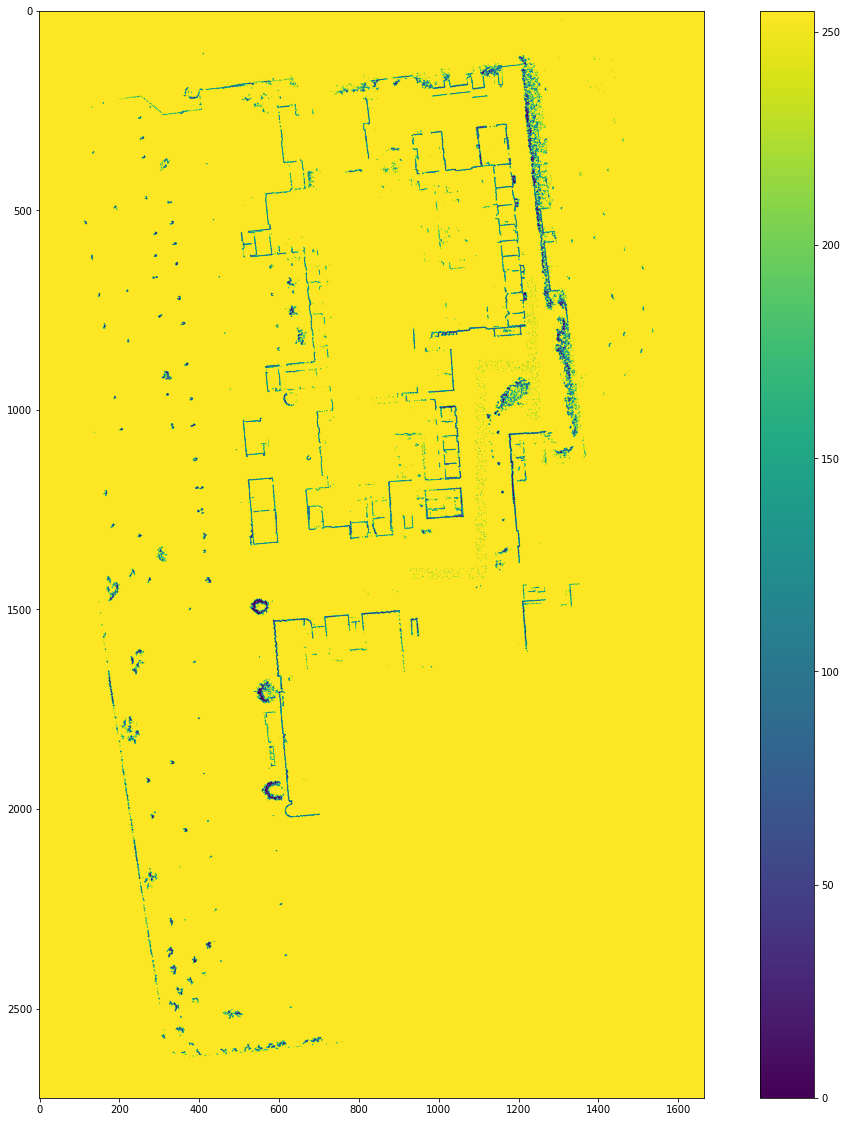

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(map_img)
plt.colorbar()
plt.grid(False)
plt.show()

#test artificial lidar

In [17]:
#get one point of the trail_target
target_db_inst = laser_db.values[(200*360)]

target_xy = target_db_inst[4:6]

In [18]:
min_dist = 0.0001
j = 1
result_pnt = []
cnt = []

for i in trail_target:
    dist = np.sqrt(np.power((i[0]-target_xy[0]),2)+np.power((i[1]-target_xy[1]),2))
    if dist < min_dist:
        result_pnt.append(i)
        cnt.append(j)
    j +=1



In [19]:
laser_inst_db = []
laser_inst_target = []

In [20]:
inst = []
rot = 0

for c in cnt:
    c = cnt[0]

    for i in laser_db_2.values:
        if i[0] == c:
            inst.append([i[2],i[3]])
            rot = i[6]

    laser_inst_db.append(inst)

if len(cnt) == 1:
    laser_inst_db = laser_inst_db[0]

In [21]:
for i in laser_db.values:
    if (i[4] == target_xy[0]) and (i[5] == target_xy[1]):
        laser_inst_target.append([i[2],i[3]])

for i in laser_inst_target:
    if i[1] == np.inf:
        i[1] = 20

In [124]:
#function of the creation of the instace LiDAR

def create_lidar(x, y, r, map):
    #correzione assi
    #x=map.shape[0]-x-1
    #r=r-180

    #if the position of the image is not a free space (obstacle or unknown) it returns None
    if map[x][y] != 254:
        return None
    else:
        #create an artificial LiDAR based on the neibourhood pixels
        result = look_around(map,x,y,r,int(20/0.05))
        return result

def look_around(map,x,y,r,dist):
    result = {}

    for i in range(360):
        angle = ((i + r) % 360)
        lidar_range = get_range(map, x, y, np.radians(angle),dist)
        result["range{}".format(i)] = lidar_range*0.05
        result["angle{}".format(i)] = np.around(np.radians((i-180)),decimals=5)  

    return result

def get_range(map,x,y,rad,dist):

    for i in range(dist):
        x_range = np.cos(rad) * i
        y_range = np.sin(rad) * i
        if map[x+int(x_range)][y+int(y_range)] != 254:
            break

    if map[x+int(x_range)][y+int(y_range)] == 0:
        
        return min(np.sqrt((np.power(int(x_range),2))+(np.power(int(y_range),2))), dist)
    
    return dist

In [152]:
x = int(target_db_inst[5]//0.05)
y = int(target_db_inst[4]//0.05)

r= np.degrees(target_db_inst[6])

laser_inst_db = []
laser_inst_db_raw = create_lidar(x,y,r,map_img)

for i in range(360):
    temp = []
    temp.append(laser_inst_db_raw["angle{}".format(i)])
    temp.append(laser_inst_db_raw["range{}".format(i)])
    laser_inst_db.append(temp)

In [116]:
np.degrees(rot)

-18.999999999999996

In [117]:
np.degrees(target_db_inst[6])

143.10079299628416

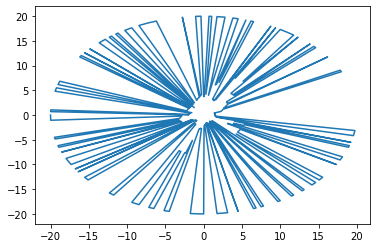

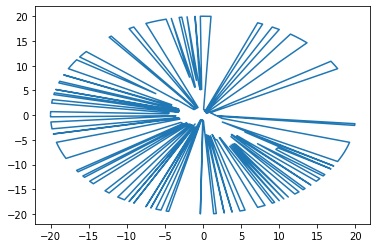

In [22]:
test_laser_db=[]
test_laser_target=[]
test_laser_difference = []

corr_angle = 0

for i in range(360):
    angle = (i-180)
    test_laser_db.append([(np.cos(np.radians(angle))*laser_inst_db[(i+corr_angle)%360][1]),(np.sin(np.radians(angle))*laser_inst_db[(i+corr_angle)%360][1])])
    test_laser_target.append([(np.cos(np.radians(angle))*laser_inst_target[i][1]),(np.sin(np.radians(angle))*laser_inst_target[i][1])])
    cos_diff = np.cos(np.radians(angle))*(laser_inst_db[(i+corr_angle)%360][1] - laser_inst_target[i][1])
    sin_diff = np.sin(np.radians(angle))*(laser_inst_db[(i+corr_angle)%360][1] - laser_inst_target[i][1])
    test_laser_difference.append([cos_diff,sin_diff])

test_laser_db = np.array(test_laser_db)
test_laser_target = np.array(test_laser_target)
test_laser_difference = np.array(test_laser_difference)

plt.plot(test_laser_target[:,0],test_laser_target[:,1])
plt.show()
plt.plot(test_laser_db[:,0],test_laser_db[:,1])
plt.show()

#plt.plot(test_laser_difference[:,0],test_laser_difference[:,1])
#plt.show()


In [ ]:

for laser in laser_inst_db:
    test_laser_target=[]

    for i in range(720):
        angle = (i-360)/2
        test_laser_target.append([(np.cos(np.radians(angle))*laser[i][1]),(np.sin(np.radians(angle))*laser[i][1])])

    test_laser_target = np.array(test_laser_target)

    plt.plot(test_laser_target[:,0],test_laser_target[:,1])
    plt.show()


In [153]:
test_laser_difference = []

for c in range(360):
    sum_diff = 0

    for i in range(360):
        angle = (i-180)
        cos_diff = np.cos(np.radians(angle))*(laser_inst_db[(i+c)%360][1] - laser_inst_target[i][1])
        sin_diff = np.sin(np.radians(angle))*(laser_inst_db[(i+c)%360][1] - laser_inst_target[i][1])
        sum_diff += np.abs(cos_diff) + np.abs(sin_diff)

    test_laser_difference.append(sum_diff)

print(np.argmin(test_laser_difference))

271


In [17]:
diff_list = []
db_array = laser_db.values.copy()
db_array_target = laser_db_2.values.copy()

for num in range(len(trail)):
    
    test_laser_difference = []
    laser_inst_db = []
    laser_inst_target = []

    for index in range(360):
        laser_inst_db.append([db_array[((num*360)+index)][2],db_array[((num*360)+index)][3]])
        laser_inst_target.append([db_array_target[((num*360)+index)][2],db_array_target[((num*360)+index)][3]])

    for c in range(360):
        sum_diff = 0
        
        for i in range(360):
            angle = (i-180)
            cos_diff = np.cos(np.radians(angle))*(laser_inst_db[(i+c)%360][1] - laser_inst_target[i][1])
            sin_diff = np.sin(np.radians(angle))*(laser_inst_db[(i+c)%360][1] - laser_inst_target[i][1])
            sum_diff += np.abs(cos_diff) + np.abs(sin_diff)

        test_laser_difference.append(sum_diff)

    diff_list.append(np.argmin(test_laser_difference))
    print(num)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [9]:
dict_diff= {}

for i in diff_list:
    
    if i in dict_diff.keys():
        dict_diff[i]+=1
    else:
        dict_diff[i]=1

dict_diff

{90: 408,
 89: 287,
 91: 60,
 92: 44,
 88: 94,
 87: 111,
 86: 61,
 93: 13,
 94: 2,
 85: 20,
 84: 3}

In [18]:
dict_diff= {}

for i in diff_list:
    
    if i in dict_diff.keys():
        dict_diff[i]+=1
    else:
        dict_diff[i]=1

dict_diff

{0: 404,
 359: 303,
 1: 64,
 2: 46,
 358: 109,
 357: 82,
 356: 54,
 3: 17,
 5: 1,
 4: 1,
 355: 18,
 354: 3,
 353: 1}

In [ ]:
laser_inst_target = np.array(laser_inst_target)
laser_inst_db = np.array(laser_inst_db)

#plt.plot(laser_inst_db[:,0], laser_inst_db[:,1],label="db")
#plt.plot(laser_inst_target[:,0], laser_inst_target[:,1], label="target")
#plt.legend()
#plt.show()

for i in laser_inst_db:
    i = np.array(i)
    plt.plot(i[:,0], i[:,1])
    plt.plot(laser_inst_target[:,0], laser_inst_target[:,1])
    plt.show()

In [13]:
for i in result_pnt:
    x = int(i[0] // 0.05) #288
    y = 428-int(i[1] // 0.05) #428
    map_img[y][x] = 205

x = int(target_xy[0] // 0.05) #288
y = 428-int(target_xy[1] // 0.05) #428
map_img[y][x] = 0

In [ ]:
plt.figure(figsize=(30,30))
plt.imshow(map_img)
plt.colorbar()
plt.grid(False)
plt.show()

In [45]:
with open('datasetnowall.csv', 'w') as f:
    f.write("cnt;time;angle;range;pos_x;pos_y;pos_yaw\n")
    for item in laser_db.values:
        
        f.write("{};{};{};{};{};{};{}\n".format(item[0],item[1],item[2],item[3],item[4],item[5],item[6]))
        

#Save an image from numpy array

In [3]:
with open("my_map.csv", "r") as data:
    map_csv = pd.read_csv(data, delimiter=";").copy()

map_csv = map_csv*254

In [4]:
from PIL import Image
import numpy as np

img = Image.fromarray(map_csv.values.astype(np.uint8))
img.save("my_map.png")